In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from dython.nominal import associations
%matplotlib inline

# Location of source data: https://www.kaggle.com/datasets/zynicide/wine-reviews
# Helpful article for correlating categorical variables: https://blog.knoldus.com/how-to-find-correlation-value-of-categorical-variables/

# load in data
wine = pd.read_csv('winemag-data-130k-v2.csv')

# Lets start by investigating our data
## What do we see?
### Explore/clean the data

In [47]:
wine

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


# We see an unexpected column : Unnamed: 0
## Lets drop it

In [48]:
wine.drop(columns=['Unnamed: 0'], inplace= True)
wine.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

# Next lets check for any missing values:

In [49]:
# Are we dealing with any null values?
def checkNulls(df):
    '''take in a dataframe check for any missing columns. If there are any columns with missing values alert the user'''
    no_nulls = set(df.columns[df.isnull().mean()==0])#Provide a set of columns with 0 missing values.
    if len(no_nulls) == len(df.columns):
        return
    else:
        print("There are missing columns in the data set. Here are the columns with missing values:")
        nulls = set(df.columns[df.isnull().mean()!=0])
        print(nulls)
 
# As we can see from the output, there are missing values. We will deal with them below.    
checkNulls(wine)

There are missing columns in the data set. Here are the columns with missing values:
{'price', 'designation', 'region_2', 'province', 'taster_twitter_handle', 'taster_name', 'region_1', 'variety', 'country'}


# Lets deal with those missing values
## Since we are specifically interested in Country and Price, we will drop all rows where these values are null. 
## Fill the other fields with empty string.

In [50]:
# Considering our business questions -> We will drop the following columns
    # Country, price
# We will replace 
    # variety,region_2,taster_twitter_handle,province,region_1,designation,tastername : ' '
wine.dropna(subset=['price','country'], inplace= True)
wine['region_2'] = wine['region_2'].fillna(value = '')
wine['variety'] = wine['variety'].fillna(value = '')
wine['taster_twitter_handle'] = wine['taster_twitter_handle'].fillna(value = '')
wine['province'] = wine['province'].fillna(value = '')
wine['region_1'] = wine['region_1'].fillna(value = '')
wine['designation'] = wine['designation'].fillna(value = '')
wine['taster_name'] = wine['taster_name'].fillna(value = '')

# Do we still have missing values?

In [51]:
checkNulls(wine)

# Lets start looking at our first business question:
## What country has the best wine overall
### Visualize the data

In [81]:
# Let us start by answering our first question:
temp = wine[['country', 'price', 'points']]
countryGroup = temp.groupby('country').mean().reset_index()
countryGroup.sort_values(by=['points'], ascending=False, inplace= True)
countryGroup.head()

,country,price,points
13,England,51.681159,91.550725
19,India,13.333333,90.222222
3,Austria,30.762772,90.190782
16,Germany,42.257547,89.836321
7,Canada,35.712598,89.377953


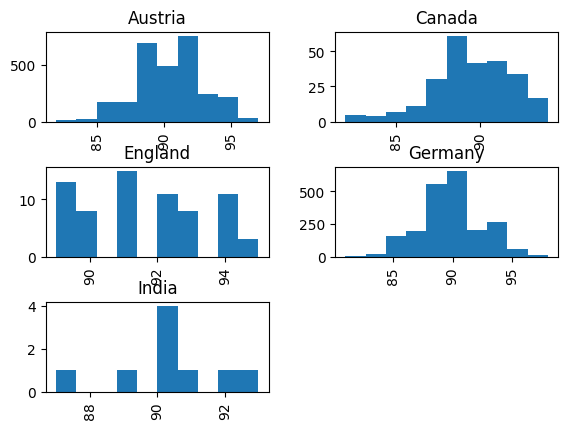

In [88]:
topCountry = wine.copy()
topCountry = topCountry.loc[topCountry['country'].isin(['England','India','Austria','Germany','Canada'])]
topCountry

topCountry['points'].hist(by = topCountry['country']);

In [53]:
temp = wine[['country', 'price', 'points']]
countryGroup = temp.groupby('country').max()
countryGroup.sort_values(by=['points'], ascending=False, inplace= True)
countryGroup.head()

,price,points
country,,
Italy,900.0,100
France,3300.0,100
Australia,850.0,100
US,2013.0,100
Portugal,1000.0,100


In [54]:
temp = wine[['country', 'price', 'points']]
countryGroup = temp.groupby('country').min()
countryGroup.sort_values(by=['points'], ascending=True, inplace= True)
countryGroup.head()

,price,points
country,,
Argentina,4.0,80
US,4.0,80
Spain,4.0,80
Portugal,5.0,80
Peru,10.0,80


<Axes: >

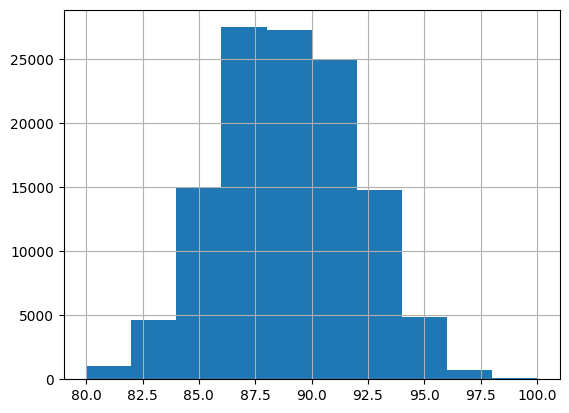

In [73]:
wine['points'].hist();

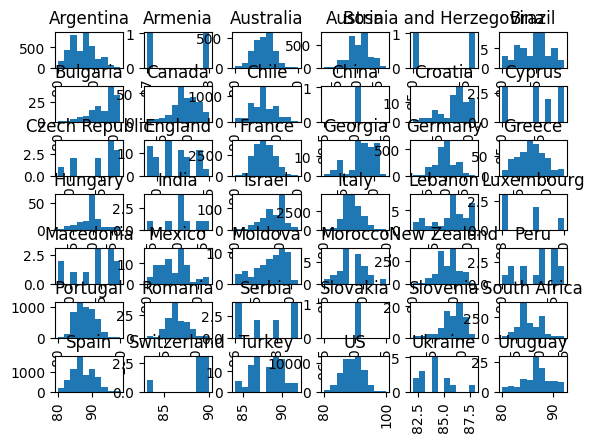

In [75]:
wine['points'].hist(by = wine['country']);

## So England makes the best wine by country, what do the top 5 provinces for wine look like?

In [55]:
temp = wine[['province', 'price', 'points']]
provinceGroup = temp.groupby('province').mean()
provinceGroup.sort_values(by=['points'], ascending=False, inplace=True)
provinceGroup.head()

,price,points
province,,
Südburgenland,57.000000,94.000000
Madeira,115.181818,93.909091
Mittelrhein,30.500000,92.250000
Puente Alto,84.500000,91.857143
Wachau,45.902597,91.665584


# Lets address our second question:
## What kind of relationship exists between price and the scoring of a wine?

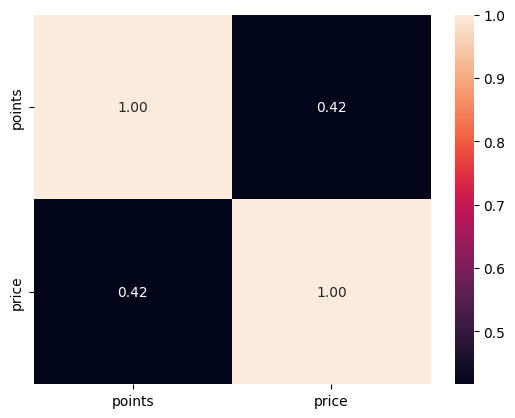

In [56]:
# Generate a heatmap to see correlation between variables in our dataframe 
numeric = wine.select_dtypes(include=['int','float']) 
sns.heatmap(numeric.corr(), annot=True, fmt=".2f");

# Only two variables for the correlation matrix?
## lets look at all the data types

In [57]:
wine.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

# Lets encode the most important categorical columns and try a new heatmap
## lets assume the tasters are unbiased, remove their names and twitter handles from the dataset. We'll also remove region_1 and region_2 since we have so many location fields 

In [58]:
# Play around with smaller subsets of below. Encoding all of these takes a long time to run. 
# province = pd.get_dummies(wine['province'], drop_first= True)
country = pd.get_dummies(wine['country'], drop_first= True)
# description = pd.get_dummies(wine['description'], drop_first= True)
# designtaion = pd.get_dummies(wine['designation'], drop_first= True)
# variety = pd.get_dummies(wine['variety'], drop_first= True)
# winery = pd.get_dummies(wine['winery'], drop_first= True)
newWine = wine.copy()
newWine.drop(columns=['province','country','description','designation','variety','winery',
                   'region_1','region_2','taster_name','taster_twitter_handle','title'], inplace=True)
# encodedWine = pd.concat([wine,province,country,description,designtaion,variety,winery], axis= 1)
encodedWine = pd.concat([newWine,country], axis= 1)

In [59]:
print(encodedWine.shape) # Lots of extra columns -> How will this effect our model?
print(encodedWine.dtypes)

(120916, 43)
points                      int64
price                     float64
Armenia                      bool
Australia                    bool
Austria                      bool
Bosnia and Herzegovina       bool
Brazil                       bool
Bulgaria                     bool
Canada                       bool
Chile                        bool
China                        bool
Croatia                      bool
Cyprus                       bool
Czech Republic               bool
England                      bool
France                       bool
Georgia                      bool
Germany                      bool
Greece                       bool
Hungary                      bool
India                        bool
Israel                       bool
Italy                        bool
Lebanon                      bool
Luxembourg                   bool
Macedonia                    bool
Mexico                       bool
Moldova                      bool
Morocco                      bool
N

# We have to drop some columns, the sns heatmap will crash otherwise. 

<Axes: >

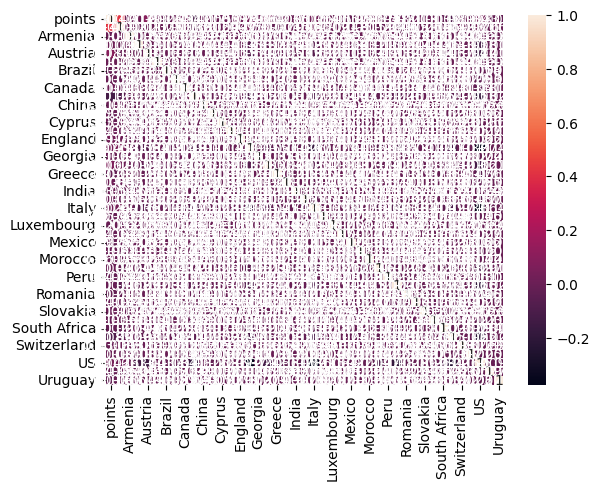

In [60]:
sns.heatmap(encodedWine.corr(), annot=True)

# Very hard to read, lets try this using a new package.
### Note: We have to severely restrict the number of variables passed to the associations() method. Otherwise fatal crash occurs.

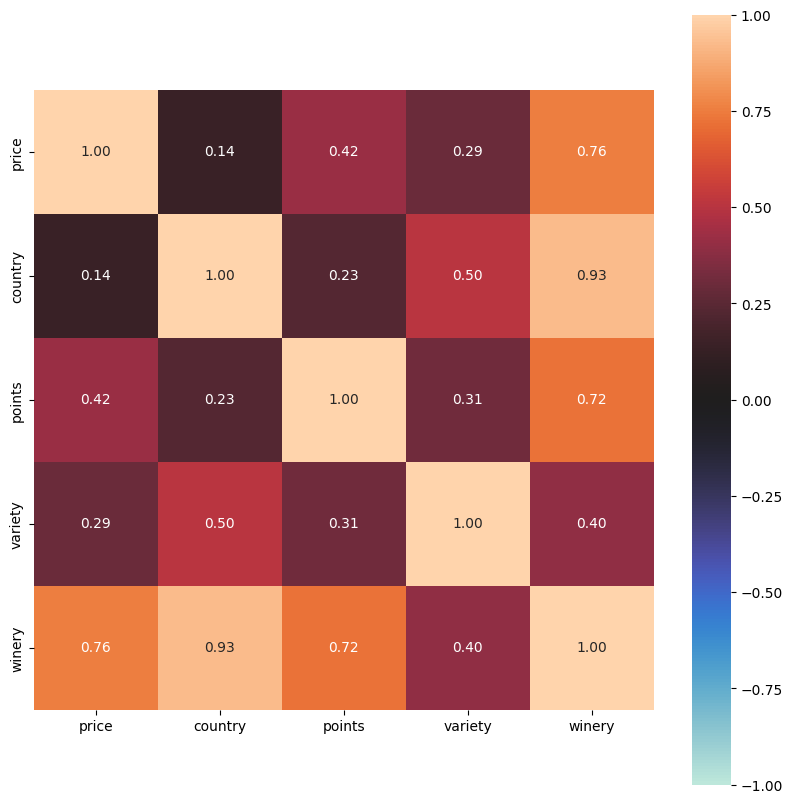

In [89]:
# Limit what we pass to the association function. I think hte below are most important.
tempWine = wine[['price','country','points','variety','winery']]

correlation = associations(tempWine, filename= 'CorrMatrix.png',figsize=(10,10))

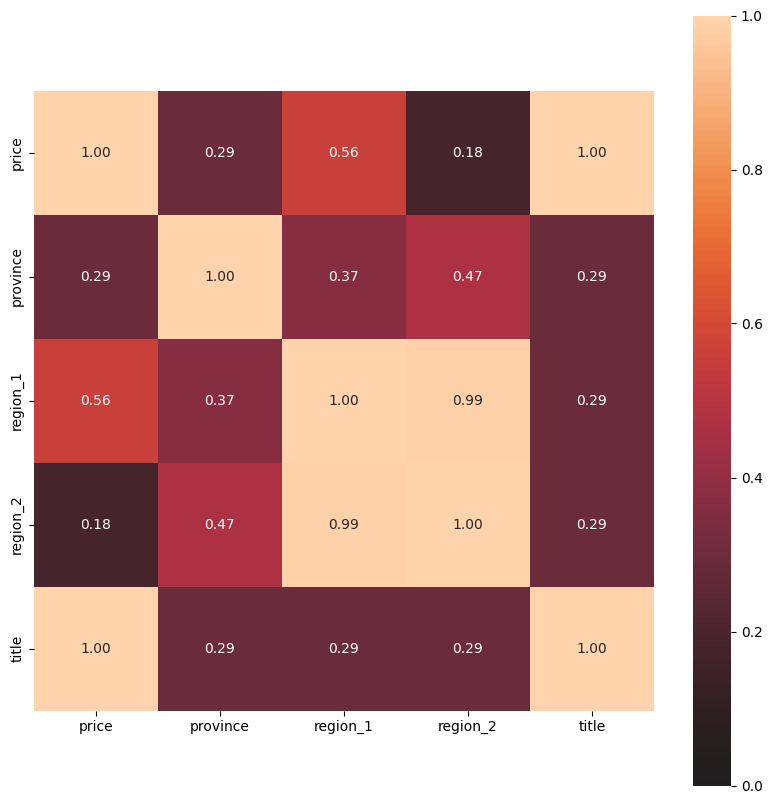

In [91]:
tempWine2 = wine[['price','province','region_1','region_2','title']]
correlation = associations(tempWine2, filename= 'CorrMatrix2.png',figsize=(10,10))

# Finally, lets answer our third business question
## What features are most important when predicting the score of a wine?

### Lets prep our data for our model. 
### Model the data


In [102]:
def prepData(tag):
    wineModelData = wine.copy()
    # Restricting our data to first 50000 rows.
    wineModelData = wineModelData.iloc[:25000]
    if tag == 1:
        country = pd.get_dummies(wineModelData['country'], drop_first= True)
        wineModelData.drop(columns=['province','country','description','designation','variety','winery',
                   'region_1','region_2','taster_name','taster_twitter_handle','title'], inplace=True)
        encodedWine = pd.concat([wineModelData,country], axis= 1)
        return encodedWine
    elif tag == 2:
        variety = pd.get_dummies(wineModelData['variety'], drop_first= True)
        wineModelData.drop(columns=['province','country','description','designation','variety','winery',
                   'region_1','region_2','taster_name','taster_twitter_handle','title'], inplace=True)
        encodedWine = pd.concat([wineModelData,variety], axis= 1)
        return encodedWine
    elif tag == 3:
        winery = pd.get_dummies(wineModelData['winery'], drop_first= True)
        wineModelData.drop(columns=['province','country','description','designation','variety','winery',
                   'region_1','region_2','taster_name','taster_twitter_handle','title'], inplace=True)
        encodedWine = pd.concat([wineModelData,winery], axis= 1)
        return encodedWine
    elif tag == 4:
        province = pd.get_dummies(wineModelData['province'], drop_first= True)
        wineModelData.drop(columns=['province','country','description','designation','variety','winery',
                   'region_1','region_2','taster_name','taster_twitter_handle','title'], inplace=True)
        encodedWine = pd.concat([wineModelData,province], axis= 1)
        return encodedWine
    else:
       province = pd.get_dummies(wineModelData['province'], drop_first= True)
       winery = pd.get_dummies(wineModelData['winery'], drop_first= True)
       variety = pd.get_dummies(wineModelData['variety'], drop_first= True) 
       country = pd.get_dummies(wineModelData['country'], drop_first= True)
       wineModelData.drop(columns=['province','country','description','designation','variety','winery',
                   'region_1','region_2','taster_name','taster_twitter_handle','title'], inplace=True)
       encodedWine = pd.concat([wineModelData,province,country,winery,variety], axis= 1)
       return encodedWine 

    # encodedWine = pd.concat([wine,province,country,description,designtaion,variety,winery], axis= 1)
    
    return 

### Set up model function

In [106]:
# Start to answer #3
def evaluateModel(data, testSize, randomState):
    target = data['points']
    data.drop(columns=['points'],inplace=True)
    X = data
    y = target

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state=randomState) 

    lm_model = LinearRegression() # Instantiate
    lm_model.fit(X_train, y_train) #Fit
    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    print(f'Train Score = {train_score} and the Test Score = {test_score}')

# Lets evaluate our model.
## We will evaluate it 4 different ways

In [107]:
data1 = prepData(1)
evaluateModel(data1, .3, 62)

data2 = prepData(2)
evaluateModel(data2, .3, 62)

data3 = prepData(3)
evaluateModel(data3, .3, 62)

data4 = prepData(4)
evaluateModel(data4, .3, 62)

Train Score = 0.19098647332822405 and the Test Score = 0.23104890279438517
Train Score = 0.22522056258311351 and the Test Score = -5.2888558199406374e+17
Train Score = 0.705873777024258 and the Test Score = -1.8795160183386608e+17
Train Score = 0.23776385064907457 and the Test Score = 0.26295031358085663


# Example of how poor the score is when using all of the fields we encoded

In [108]:
data4 = prepData(5)
evaluateModel(data4, .3, 62)

Train Score = 0.730692333806128 and the Test Score = -7.312797739866278e+16
